### Setup

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns

## Task 1 - Geocoding

### Write up
To geocode addresses as many as possible, we first transferred the streets suffixes in the park and pluto dataframes to the corresponding abbreviations according to https://pe.usps.com/text/pub28/28apc_002.htm, which helped us find about 700k matched records in the park. Then, we unified the last digit of the street number before the street name as 0 because we believed that the original addresses and the modified ones are in the same precinct. This step helped us match approximately all the records in the park. Next, based on the modified addresses, we identified potential precinct mismatches out of typographical error or misprint, which means many tickets with one single address corresponding to multiple precincts. Thus, we replaced all precincts in a single address with the highest probability one. The No.3 subplot improves at the bottom blue and green areas compared to the No.2 subplot. Finally, We removed the outliers for each precinct to address precinct mismatches by checking whether the value latitude/longitude was outside the 2.5-sigma area. For the missingness of latitudes and longitudes of the central park precinct (22), we imputed the data through *meshgrid* in the central park rectangular. The latitudes and longitudes of the four corners of central park were copied from Google Maps. 


### Implementation

#### Step 1: Unifying common terms

In [4]:
# Avenue -> AVE
# WEST + -> W
# EAST +  -> E
# STREET -> ST
# NORTH + -> N
# Boulevard -> BLVD
# Broadway -> BDWY
# Parkway -> PKWY
# ROAD -> RD
# SQUARE -> SQ
# TERRACE -> TERR
# ALLEY -> ALY
# CIRCLE -> CIR
# DRIVE -> DR
# HIGHWAY -> HWY
# PLACE -> PL
# PLAZA -> PLZ

In [5]:
park = pd.read_csv("data/manh_tickets_2019.csv.zip")
pluto = pd.read_csv("data/manh_pluto.csv")

In [6]:
park['address'] = park['address'].str.upper()
pluto['address'] = pluto['address'].str.upper()

In [7]:
park_new = park.apply(lambda x: x.replace({' AVENUE':' AVE', 'WEST':'W',
'EAST':'E', ' STREET' : ' ST','NORTH':'N','SOUTH':'S',' BOULEVARD':' BLVD',' BROADWAY':' BDWY',
' PARKWAY':' PKWY',' ROAD':' RD',' SQUARE':' SQ',' TERRACE':' TERR',' ALLEY':' ALY',' CIRCLE':' CIR',
' DRIVE':' DR',' HIGHWAY':' HWY',' PLACE':' PL',' PLAZA':' PLZ'}, regex=True))

In [8]:
park_address = park_new['address'].copy()
park_address.head()

0       2526 BDWY
1       2373 BDWY
2       2373 BDWY
3     79 E 2ND ST
4    232 E 6TH ST
Name: address, dtype: object

In [9]:
pluto_new =pluto.apply(lambda x: x.replace({' AVENUE':' AVE', 'WEST':'W',
'EAST':'E', ' STREET' : ' ST','NORTH':'N','SOUTH':'S',' BOULEVARD':' BLVD',' BROADWAY':' BDWY',
' PARKWAY':' PKWY',' ROAD':' RD',' SQUARE':' SQ',' TERRACE':' TERR',' ALLEY':' ALY',' CIRCLE':' CIR',
' DRIVE':' DR',' HIGHWAY':' HWY',' PLACE':' PL',' PLAZA':' PLZ'}, regex=True))

In [10]:
# we found the missing values in pluto is very few, so we simply drop it
pluto_new = pluto_new.dropna()

In [11]:
combined = pd.merge(park_new,pluto_new,how = "inner",on = "address")
combined

,issue_date,violation_code,address,precinct,lat,long
0,07/10/2018,21,2373 BDWY,24,40.788924,-73.976671
1,07/10/2018,21,2373 BDWY,24,40.788924,-73.976671
2,07/13/2018,37,2373 BDWY,24,40.788924,-73.976671
3,06/28/2018,21,2373 BDWY,20,40.788924,-73.976671
4,06/25/2018,21,2373 BDWY,20,40.788924,-73.976671
...,...,...,...,...,...,...
694113,05/29/2019,20,209 SULLIVAN ST,6,40.729225,-73.999744
694114,06/03/2019,46,369 GREENWICH ST,6,40.719300,-74.010018
694115,06/13/2019,14,244 LENOX AVE,28,40.805884,-73.946363
694116,06/03/2019,17,58 HESTER ST,7,40.715734,-73.990982


#### Step 2: Unifying the last digit of the street number as 0

In [12]:
## Helper function that turn any street number's last digit to 0
def zero_apt(str):
    """
    Description:
      zero_apt is used to make the last digit of the street number as zero
    
    Parameter:
      str: a string, should be the address
    
    Output:
      A new address with the last digit in the street number as zero
    """
    
    split = str.split()
    split[0] = split[0][:-1]+"0"
    new_str = " ".join(split)
    return new_str

In [13]:
## turn any street number's last digit to 0
park_new["address"] = park_new["address"].apply(zero_apt)
park_new.head()

,issue_date,violation_code,address,precinct
0,07/14/2018,21,2520 BDWY,24
1,07/10/2018,21,2370 BDWY,24
2,07/10/2018,21,2370 BDWY,24
3,07/13/2018,21,70 E 2ND ST,9
4,07/13/2018,21,230 E 6TH ST,9


In [14]:
## turn any street number's last digit to 0
pluto_new["address"] = pluto_new["address"].apply(zero_apt)
pluto_new.head()

,address,lat,long
0,20 S ST,40.702609,-74.009900
1,0 S ST,40.700369,-74.012911
2,0 PIER 6,40.701171,-74.009243
3,10 BATTERY PARK,40.702806,-74.015631
4,0 ST,40.701255,-74.013939


In [15]:
combined2 = pd.merge(park_new,pluto_new,how = "inner",on = "address")
combined2

,issue_date,violation_code,address,precinct,lat,long
0,07/14/2018,21,2520 BDWY,24,40.793301,-73.972101
1,07/14/2018,21,2520 BDWY,24,40.793674,-73.973036
2,07/14/2018,21,2520 BDWY,24,40.793474,-73.972061
3,07/10/2018,37,2520 BDWY,24,40.793301,-73.972101
4,07/10/2018,37,2520 BDWY,24,40.793674,-73.973036
...,...,...,...,...,...,...
3746733,06/06/2019,94,0 RIVERVIEW TERR,17,40.758109,-73.959457
3746734,06/06/2019,94,0 RIVERVIEW TERR,17,40.758033,-73.959515
3746735,06/06/2019,40,550 W ST,9,40.740091,-74.008560
3746736,06/24/2019,46,110 BROAD ST,1,40.702776,-74.010722


#### Step 3: Handling potential precinct mismatches

In [16]:
# convert address into the original one 
park_new['address'] = park_address
park_new['address'].head()

0       2526 BDWY
1       2373 BDWY
2       2373 BDWY
3     79 E 2ND ST
4    232 E 6TH ST
Name: address, dtype: object

In [17]:
## impute misspecified precinct in park dataset
## construct address-precinct dataframe
add_pre = (park_new.groupby(['address', 'precinct']).size()
     .reset_index(name='n')
     .sort_values(ascending=False, by=['address', 'n'])
     .drop_duplicates(subset='address')
     .drop('n', axis = 1))
add_pre.head()

,address,precinct
221143,ZERO BOND ST,9
221141,Z21 8TH AVE,6
221140,YGA W 50TH ST,18
221139,X530-550 1ST AVE,13
221138,WS PARK AVE,23


In [18]:
## park dataframe after imputation
park_new = park_new.merge(add_pre, on = 'address', how = 'left')
park_new['precinct'] = park_new['precinct_y']
park_new = park_new.drop(['precinct_x','precinct_y'], axis=1)

In [19]:
## repeat the original procedures
## turn any apt number's last digit to 0
park_new["address"] = park_new["address"].apply(zero_apt)
park_new.head()

,issue_date,violation_code,address,precinct
0,07/14/2018,21,2520 BDWY,24
1,07/10/2018,21,2370 BDWY,24
2,07/10/2018,21,2370 BDWY,24
3,07/13/2018,21,70 E 2ND ST,9
4,07/13/2018,21,230 E 6TH ST,9


In [20]:
combined3 = pd.merge(park_new,pluto_new,how = "inner",on = "address")
combined3

,issue_date,violation_code,address,precinct,lat,long
0,07/14/2018,21,2520 BDWY,24,40.793301,-73.972101
1,07/14/2018,21,2520 BDWY,24,40.793674,-73.973036
2,07/14/2018,21,2520 BDWY,24,40.793474,-73.972061
3,07/10/2018,37,2520 BDWY,24,40.793301,-73.972101
4,07/10/2018,37,2520 BDWY,24,40.793674,-73.973036
...,...,...,...,...,...,...
3746733,06/06/2019,94,0 RIVERVIEW TERR,17,40.758109,-73.959457
3746734,06/06/2019,94,0 RIVERVIEW TERR,17,40.758033,-73.959515
3746735,06/06/2019,40,550 W ST,9,40.740091,-74.008560
3746736,06/24/2019,46,110 BROAD ST,1,40.702776,-74.010722


#### Step 4: Imputing datapoints for Central Park

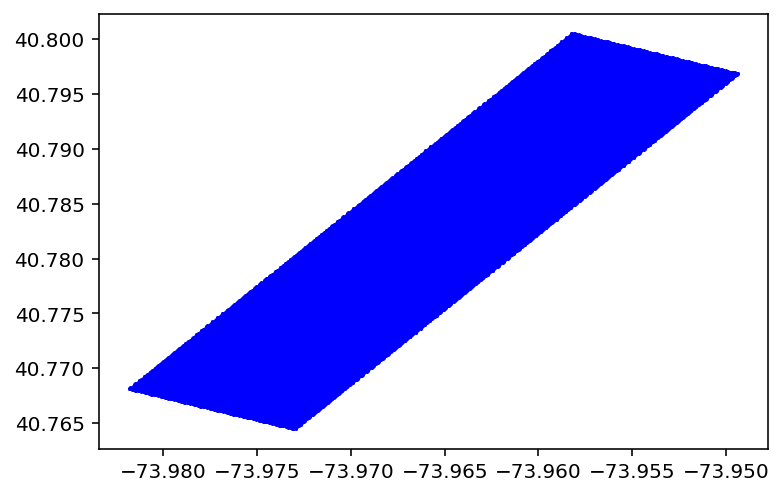

,issue_date,violation_code,address,precinct,lat,long
0,07/14/2018,21.0,2520 BDWY,24,40.793301,-73.972101
1,07/14/2018,21.0,2520 BDWY,24,40.793674,-73.973036
2,07/14/2018,21.0,2520 BDWY,24,40.793474,-73.972061
3,07/10/2018,37.0,2520 BDWY,24,40.793301,-73.972101
4,07/10/2018,37.0,2520 BDWY,24,40.793674,-73.973036
...,...,...,...,...,...,...
79523,NaN,NaN,NaN,22,40.800455,-73.957858
79524,NaN,NaN,NaN,22,40.800527,-73.958250
79525,NaN,NaN,NaN,22,40.800527,-73.958185
79526,NaN,NaN,NaN,22,40.800527,-73.958120


In [21]:
## Get in 'fake' tickets for the central park in (lat, long) format
botright = (-73.9730, 40.7644)
topright = (-73.9493, 40.7969)
botleft = (-73.9819, 40.7681)
topleft = (-73.9582, 40.8006)

## Create df_central certices for central park
data = {'long': [botleft[0], botright[0], topright[0], topleft[0]],
       'lat': [botleft[1], botright[1], topright[1], topleft[1]]}
df_central = pd.DataFrame(data)

## Create rectangular meshgrid for central park
x = np.linspace(min(df_central['long']), max(df_central['long']), 500) 
y = np.linspace(min(df_central['lat']), max(df_central['lat']), 500) 
xx, yy = np.meshgrid(x, y)

## Cut the four corners of the rectangular meshgrid to create the correct polygon shape
slopeplus = (botright[1]-botleft[1])/(botright[0]-botleft[0])
slopeminus = (topleft[1]-botleft[1])/(topleft[0]-botleft[0])
xplusy = -slopeplus*xx+yy
xminusy = slopeminus*xx-yy
inside = (xplusy > -slopeplus*botleft[0]+botleft[1]) & (xplusy < -slopeplus*topleft[0]+topleft[1]) & (xminusy > slopeminus*botleft[0]-botleft[1]) & (xminusy < slopeminus*botright[0]-botright[1])
plt.plot(xx[inside], yy[inside], 'bo', markersize=0.5)
plt.show()

## Combine the meshgrid and original data frame
df_central = pd.DataFrame({'long': xx[inside].flatten(), 'lat': yy[inside].flatten(), 'precinct': 22})
combined4 = pd.concat([combined3, df_central], axis = 0)
combined4

#### Step 5: Removing the outliers of longitude and latitude

In [22]:
def is_outlier(s):
    """
    Description:
      is_outlier is a function to remove outliers that are not within 2.5 standard deviation of the mean for each precinct
      
    Parameter:
      s: the variables that you want to remove the outliers, should be a panda series
      
    Output:
      the indices that are not outliers
    """
    lower_limit = s.mean() - (s.std() * 2.5)
    upper_limit = s.mean() + (s.std() * 2.5)
    return ~s.between(lower_limit, upper_limit)

In [23]:
combined5 = combined3[~combined3.groupby('precinct',group_keys=False)['lat'].apply(is_outlier)]
combined5

,issue_date,violation_code,address,precinct,lat,long
0,07/14/2018,21,2520 BDWY,24,40.793301,-73.972101
1,07/14/2018,21,2520 BDWY,24,40.793674,-73.973036
2,07/14/2018,21,2520 BDWY,24,40.793474,-73.972061
3,07/10/2018,37,2520 BDWY,24,40.793301,-73.972101
4,07/10/2018,37,2520 BDWY,24,40.793674,-73.973036
...,...,...,...,...,...,...
3746732,06/06/2019,94,0 RIVERVIEW TERR,17,40.757991,-73.959544
3746733,06/06/2019,94,0 RIVERVIEW TERR,17,40.758109,-73.959457
3746734,06/06/2019,94,0 RIVERVIEW TERR,17,40.758033,-73.959515
3746736,06/24/2019,46,110 BROAD ST,1,40.702776,-74.010722


In [24]:
combined5 = combined5[~combined5.groupby('precinct',group_keys=False)['long'].apply(is_outlier)]
combined5

,issue_date,violation_code,address,precinct,lat,long
0,07/14/2018,21,2520 BDWY,24,40.793301,-73.972101
1,07/14/2018,21,2520 BDWY,24,40.793674,-73.973036
2,07/14/2018,21,2520 BDWY,24,40.793474,-73.972061
3,07/10/2018,37,2520 BDWY,24,40.793301,-73.972101
4,07/10/2018,37,2520 BDWY,24,40.793674,-73.973036
...,...,...,...,...,...,...
3746727,05/29/2019,20,320 E 59 ST,18,40.759936,-73.963336
3746728,05/29/2019,20,320 E 59 ST,18,40.759969,-73.963412
3746729,05/31/2019,31,70 W 40 ST,14,40.753131,-73.984628
3746736,06/24/2019,46,110 BROAD ST,1,40.702776,-74.010722


In [25]:
combined5 = pd.concat([combined5, df_central], axis = 0)
combined5

,issue_date,violation_code,address,precinct,lat,long
0,07/14/2018,21.0,2520 BDWY,24,40.793301,-73.972101
1,07/14/2018,21.0,2520 BDWY,24,40.793674,-73.973036
2,07/14/2018,21.0,2520 BDWY,24,40.793474,-73.972061
3,07/10/2018,37.0,2520 BDWY,24,40.793301,-73.972101
4,07/10/2018,37.0,2520 BDWY,24,40.793674,-73.973036
...,...,...,...,...,...,...
79523,NaN,NaN,NaN,22,40.800455,-73.957858
79524,NaN,NaN,NaN,22,40.800527,-73.958250
79525,NaN,NaN,NaN,22,40.800527,-73.958185
79526,NaN,NaN,NaN,22,40.800527,-73.958120


#### Visualization of overall preprocessing

In [26]:
from matplotlib import colors

# create a list of 8 high contrast colors from the Set1 palette
base_colors = plt.cm.tab20.colors

# create a list of 40 high contrast colors by repeating the base colors
color_list = []
for i in range(40):
    color_list.append(base_colors[i % 20])

# create a ListedColormap from the color list
high_contrast_cmap = colors.ListedColormap(color_list)

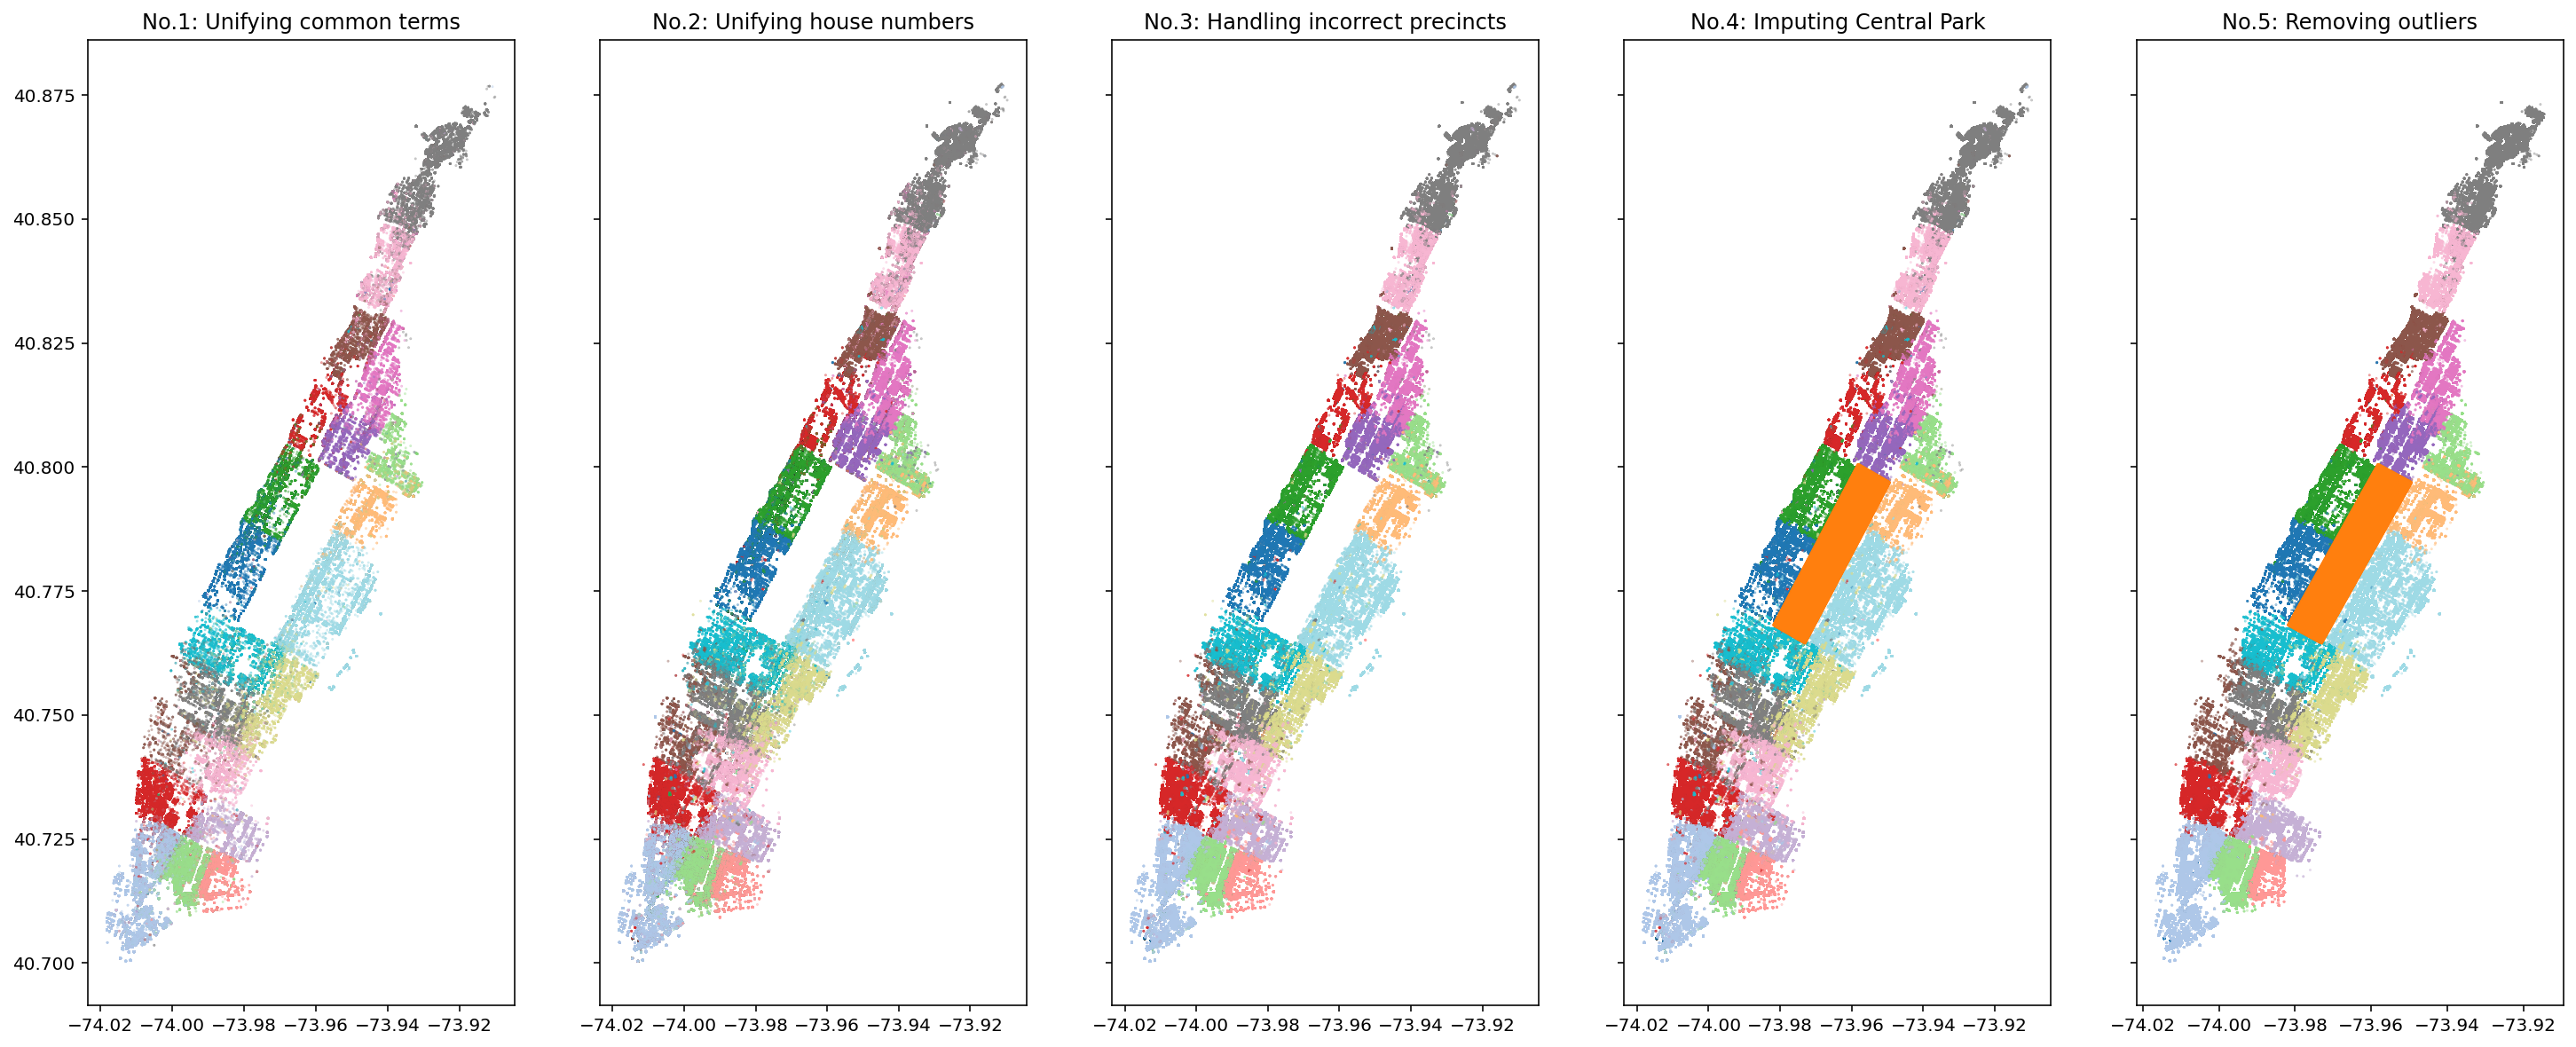

In [27]:
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(1, 5, figsize=(25, 10), sharey=True)

my_cmap = high_contrast_cmap

axs[0].scatter(combined['long'], combined['lat'], c=my_cmap(combined["precinct"]), alpha=0.5, s=0.2)
axs[1].scatter(combined2['long'], combined2['lat'], c=my_cmap(combined2["precinct"]), alpha=0.5, s=0.2)
axs[2].scatter(combined3['long'], combined3['lat'], c=my_cmap(combined3["precinct"]), alpha=0.5, s=0.2)
axs[3].scatter(combined4['long'], combined4['lat'], c=my_cmap(combined4["precinct"]), alpha=0.5, s=0.2)
axs[4].scatter(combined5['long'], combined5['lat'], c=my_cmap(combined5["precinct"]), alpha=0.5, s=0.2)

axs[0].set_title("No.1: Unifying common terms")
axs[1].set_title("No.2: Unifying house numbers")
axs[2].set_title("No.3: Handling incorrect precincts")
axs[3].set_title("No.4: Imputing Central Park")
axs[4].set_title("No.5: Removing outliers")

plt.show()


## Task 2 - Modeling

### Write up

In this task, we try random forest and K-nearest neighbors to fit longitude and latitude data. 

Since the restricted 60-minute run time, we only use 30% of our preprocessed data in Task 1 to fit models. The final result is considerably good although only using part of the data. Then, due to highly imbalance of the precincts, we apply undersampling techniques to solve this problem. Next, we split the data into training and test sets for our final overall model performance assessment. For the model pipeline, we first use the random forest to formula a binary classification problem and predict the central park area, then generalizing to the entirety of Manhattan as a multiclass classification problem. In the final model, the number of tree *n_estimators*, the maximum depth of the tree *max_depth*, and the minimum number of samples required to split an internal node *min_samples_split* are chosen to tune; the scoring metrics is *accuracy*. After using Stratified 5-fold cross-validation to perform *GridSearchCV*, we get the following best hyperparameter *'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 1000*. To assess the performance of our best random forest model, we draw a confusion matrix for our true and predicted precincts in the test set. We can see most data points are correctly classified. Also, misclassified points are pretty close to the true precincts.

For the KNN model, since the features are longitude and latitude, we use haversine distance as the model metric instead of Euclidean distance. Then, using *GridSearchCV* and Stratified 5-fold cross-validation approach to choose the best hyperparameter the number of neighbors from k=[1,10]. The scoring metric is accuracy and the final output generates the best KNN model with k=9.

In the end, we choose random forest as our final model since it has high accuracy and can generate a smoother plot by comparing the final predicted boundaries plot in Task 3.

### Implementation

In [28]:
!pip install imbalanced-learn

In [29]:
import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, accuracy_score

In [30]:
df_X = combined5[['lat', 'long']].reset_index(drop=True)
df_y = combined5['precinct'].reset_index(drop=True)

#### Applying Random Forest for this classification problem

##### Step 1: As a binary classification problem

In [31]:
# Using only 30% of the overall data
SAMPLE_SIZE_RATIO = 0.3

df_X_rfb = df_X.sample(int(len(df_X) * SAMPLE_SIZE_RATIO))
df_y_rfb = df_y.iloc[df_X_rfb.index]

In [32]:
# Convert y to binary labels and use precinct 22, central park, as an example
df_y_rfb = (df_y_rfb == 22).astype(int)

In [33]:
# As the label is highly imbalance, we applied undersampling
undersample = RandomUnderSampler(sampling_strategy=1)
Under_X, Under_y = undersample.fit_resample(df_X_rfb, df_y_rfb)

In [34]:
X = np.asarray(Under_X)
y = np.asarray(Under_y)

In [35]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ("Training dataset shape of X, Y: ", X_train.shape, y_train.shape)
print ("Testing dataset shape of X, Y: ", X_test.shape, y_test.shape)

Training dataset shape of X, Y:  (37804, 2) (37804,)
Testing dataset shape of X, Y:  (9452, 2) (9452,)


In [36]:
# Create the pipeline with an undersampling step, a StandardScaler, and a RandomForestClassifier estimator
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('randomforestclassifier', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'randomforestclassifier__n_estimators': [300], # np.linspace(100, 500, 5).astype(int),
    'randomforestclassifier__max_depth': [40] # np.linspace(10, 50, 5).astype(int)
}

# Define the scoring metrics
scoring = {
    'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr'),
    'accuracy': make_scorer(accuracy_score),
    # 'confusion_matrix': make_scorer(confusion_matrix)
}

In [37]:
# Perform a grid search with cross-validation to find the best hyperparameters
grid_search_rfb = GridSearchCV(pipe, 
                            param_grid=param_grid, 
                            scoring=scoring, 
                            refit='roc_auc_ovr', 
                            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234),
                            n_jobs = -1)
grid_search_rfb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [40],
                         'randomforestclassifier__n_estimators': [300]},
             refit='roc_auc_ovr',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'roc_auc_ovr': make_scorer(roc_auc_score, multi_class=ovr)})

In [38]:
# Print the best hyperparameters and corresponding scores
print('Best hyperparameters:', grid_search_rfb.best_params_)
print('Best mean AUC score:', grid_search_rfb.cv_results_['mean_test_roc_auc_ovr'][grid_search_rfb.best_index_])
print('Best mean accuracy score:', grid_search_rfb.cv_results_['mean_test_accuracy'][grid_search_rfb.best_index_])
# print('Best mean confusion matrix:', grid_search.cv_results_['mean_test_confusion_matrix'][grid_search.best_index_])

Best hyperparameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__n_estimators': 300}
Best mean AUC score: 0.9989160360468438
Best mean accuracy score: 0.9989154558794819


In [39]:
best_model_rfb = grid_search_rfb.best_estimator_
y_pred = best_model_rfb.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix:\n', cm)

Confusion matrix:
 [[4703    9]
 [   2 4738]]


In [40]:
X_oos = pd.read_csv("./data/manh_pred.csv")
y_pred_oos = best_model_rfb.predict(np.asarray(X_oos)) # directly predict the unnormalized dataset

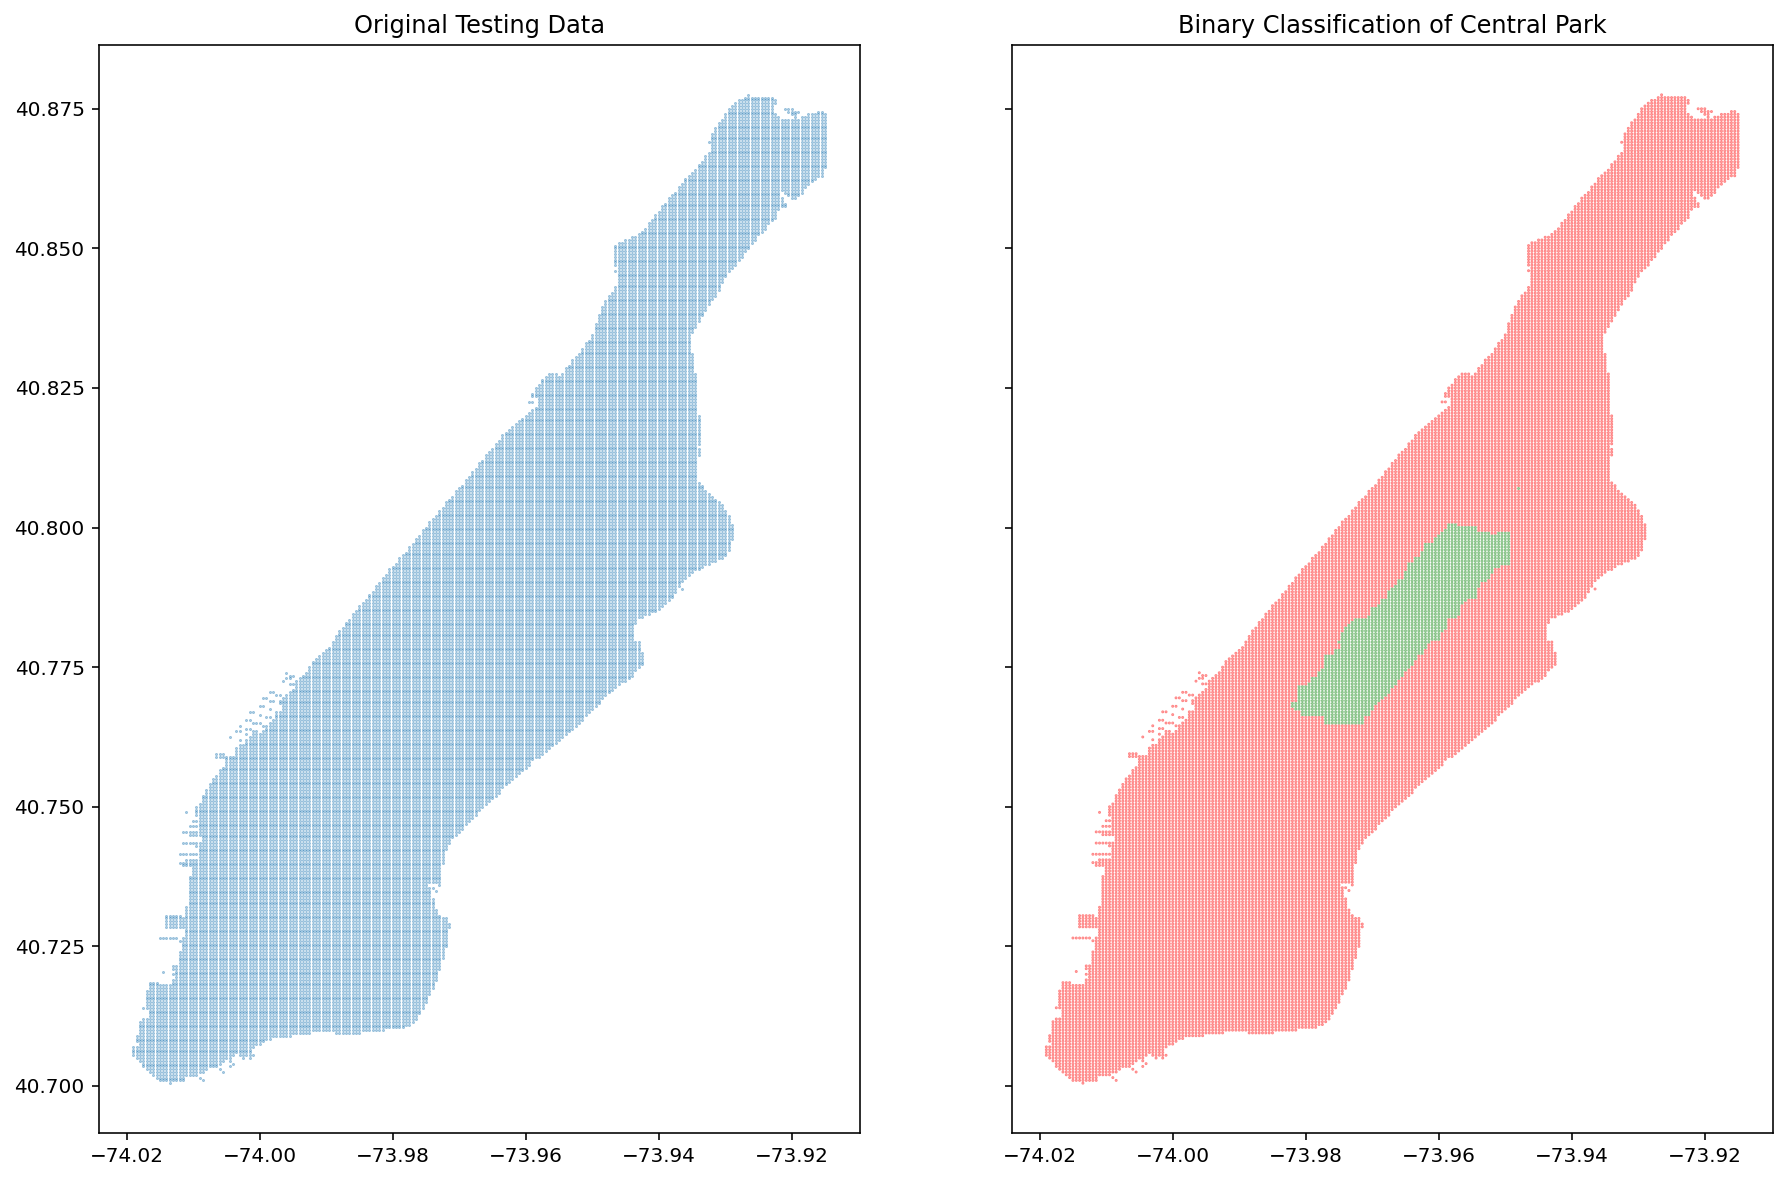

In [41]:
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)

my_cmap = ListedColormap(['red', 'green'])

axs[0].scatter(X_oos['long'], X_oos['lat'], alpha=0.5, s=0.2)
axs[1].scatter(X_oos['long'], X_oos['lat'], c=my_cmap(y_pred_oos), alpha=0.5, s=0.2)

axs[0].set_title("Original Testing Data")
axs[1].set_title("Binary Classification of Central Park")
plt.show()

##### Step 2: As a multiclass classification problem

In [712]:
# Due to execution time concern, we only use 3% data for the hyper parameter tuning and evaluate the performance
SAMPLE_SIZE_RATIO = 0.03

df_X_rfm = df_X.sample(int(len(df_X) * SAMPLE_SIZE_RATIO))
df_y_rfm = df_y.iloc[df_X_rfm.index]

In [713]:
X = np.asarray(df_X_rfm)
y = np.asarray(df_y_rfm)

In [714]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ("Training dataset shape of X, Y: ", X_train.shape, y_train.shape)
print ("Testing dataset shape of X, Y: ", X_test.shape, y_test.shape)

Training dataset shape of X, Y:  (90736, 2) (90736,)
Testing dataset shape of X, Y:  (22684, 2) (22684,)


In [716]:
# Create the pipeline with an undersampling step, a StandardScaler, and a RandomForestClassifier estimator
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('randomforestclassifier', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'randomforestclassifier__n_estimators': [1000, 1500, 2000],
    'randomforestclassifier__max_depth': [40, 50, 60], 
    # 'randomforestclassifier__max_features': ['sqrt', 'log2'], # effective to solve overfitting when having many features
    'randomforestclassifier__min_samples_leaf': [5, 10] # effective to solve overfitting when the sample size is large
}

# Define the scoring metrics
scoring = {
    # 'roc_auc_ovr': make_scorer(roc_auc_score, multi_class='ovr'),
    'accuracy': make_scorer(accuracy_score),
    # 'confusion_matrix': make_scorer(confusion_matrix)
}

In [718]:
# Perform a grid search with cross-validation to find the best hyperparameters
grid_search_rfm = GridSearchCV(pipe, 
                        param_grid=param_grid, 
                        scoring=scoring, 
                        refit='accuracy', 
                        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234), 
                        n_jobs = -1)
grid_search_rfm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [40, 50, 60],
                         'randomforestclassifier__min_samples_leaf': [5, 10],
                         'randomforestclassifier__n_estimators': [1000, 1500,
                                                                  2000]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score)})

In [719]:
# Print the best hyperparameters and corresponding scores
print('Best hyperparameters:', grid_search_rfm.best_params_)
# print('Best mean AUC score:', grid_search.cv_results_['mean_test_roc_auc_ovr'][grid_search.best_index_])
print('Best mean accuracy score:', grid_search_rfm.cv_results_['mean_test_accuracy'][grid_search_rfm.best_index_])
# print('Best mean confusion matrix:', grid_search.cv_results_['mean_test_confusion_matrix'][grid_search.best_index_])

Best hyperparameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 1000}
Best mean accuracy score: 0.9796001482468638


In [720]:
best_model_rfm = grid_search_rfm.best_estimator_
y_pred = best_model_rfm.predict(X_test)

In [721]:
X_oos = pd.read_csv("./data/manh_pred.csv")
y_pred_oos = best_model_rfm.predict(np.asarray(X_oos)) # directly predict the unnormalized dataset

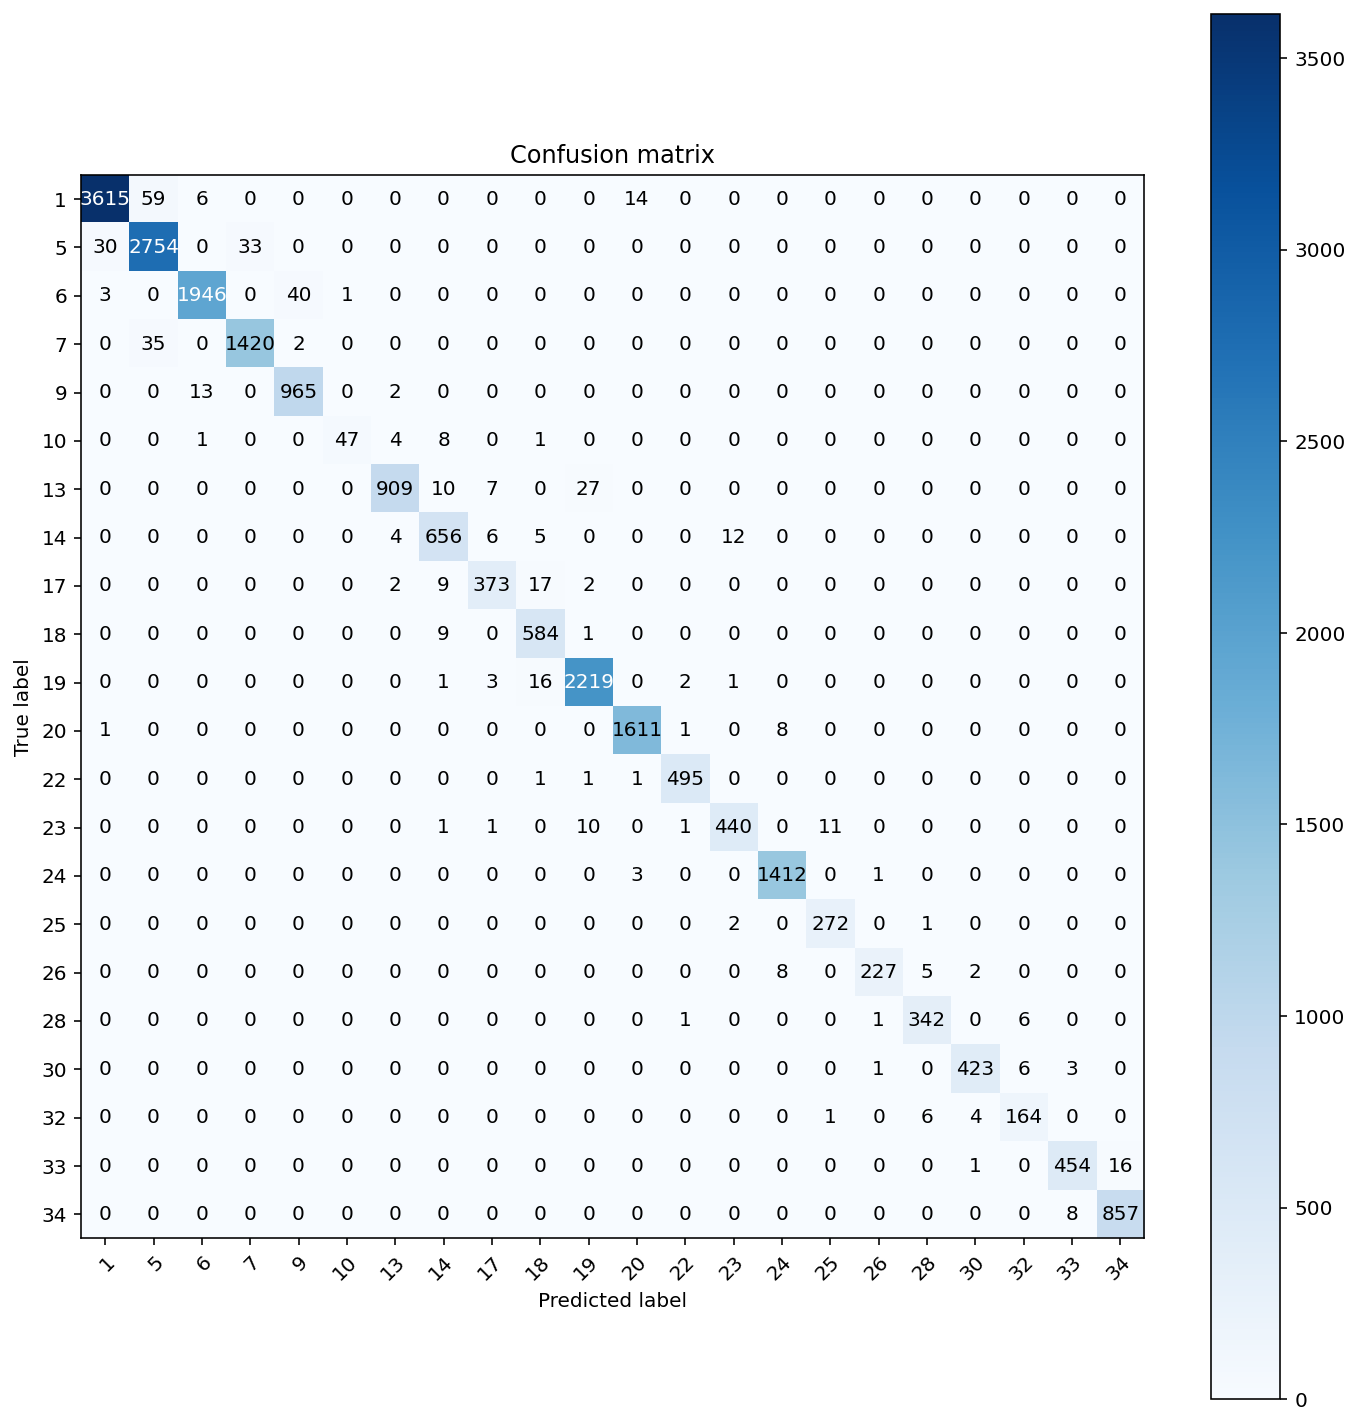

In [722]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = best_model_rfm.classes_)

# Define the class names
classes = best_model_rfm.classes_ # class names in order

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title="Confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

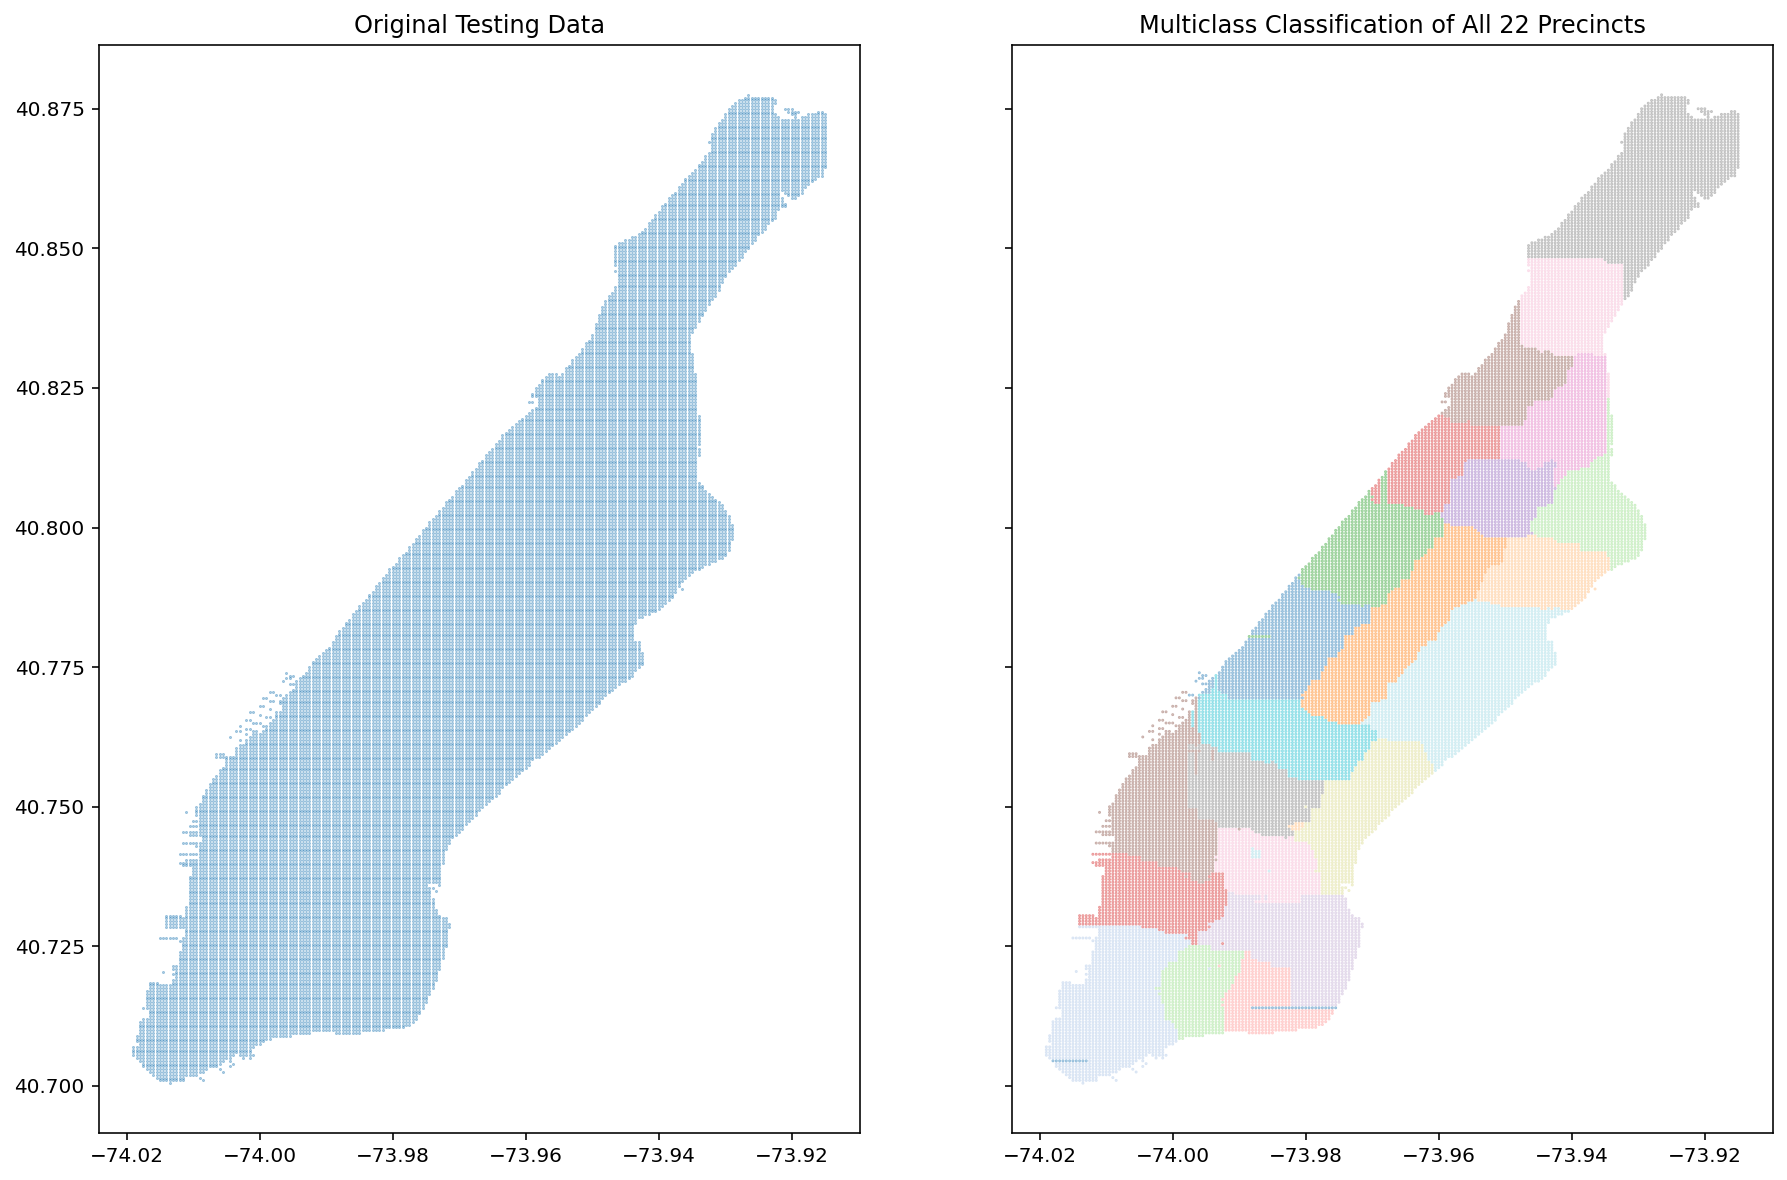

In [723]:
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey = True)

my_cmap = high_contrast_cmap

axs[0].scatter(X_oos['long'], X_oos['lat'], alpha=0.5, s=0.2)
axs[1].scatter(X_oos['long'], X_oos['lat'], c=my_cmap(y_pred_oos), alpha=0.5, s=0.2)

axs[0].set_title("Original Testing Data")
axs[1].set_title("Multiclass Classification of All 22 Precincts")

plt.show()

## Task 3 - Visualization

In [724]:
pred = pd.read_csv("data/manh_pred.csv")
bound = pd.read_csv("data/manh_bound.csv")

In [725]:
bound

,lat,long
0,40.877621,-73.926406
1,40.877592,-73.926351
2,40.877565,-73.926297
3,40.877551,-73.926310
4,40.877537,-73.926303
...,...,...
5082,40.877508,-73.926608
5083,40.877584,-73.926531
5084,40.877618,-73.926482
5085,40.877610,-73.926416


In [726]:
y_bound_oos = best_model_rfm.predict(np.asarray(bound)) # directly predict the unnormalized dataset

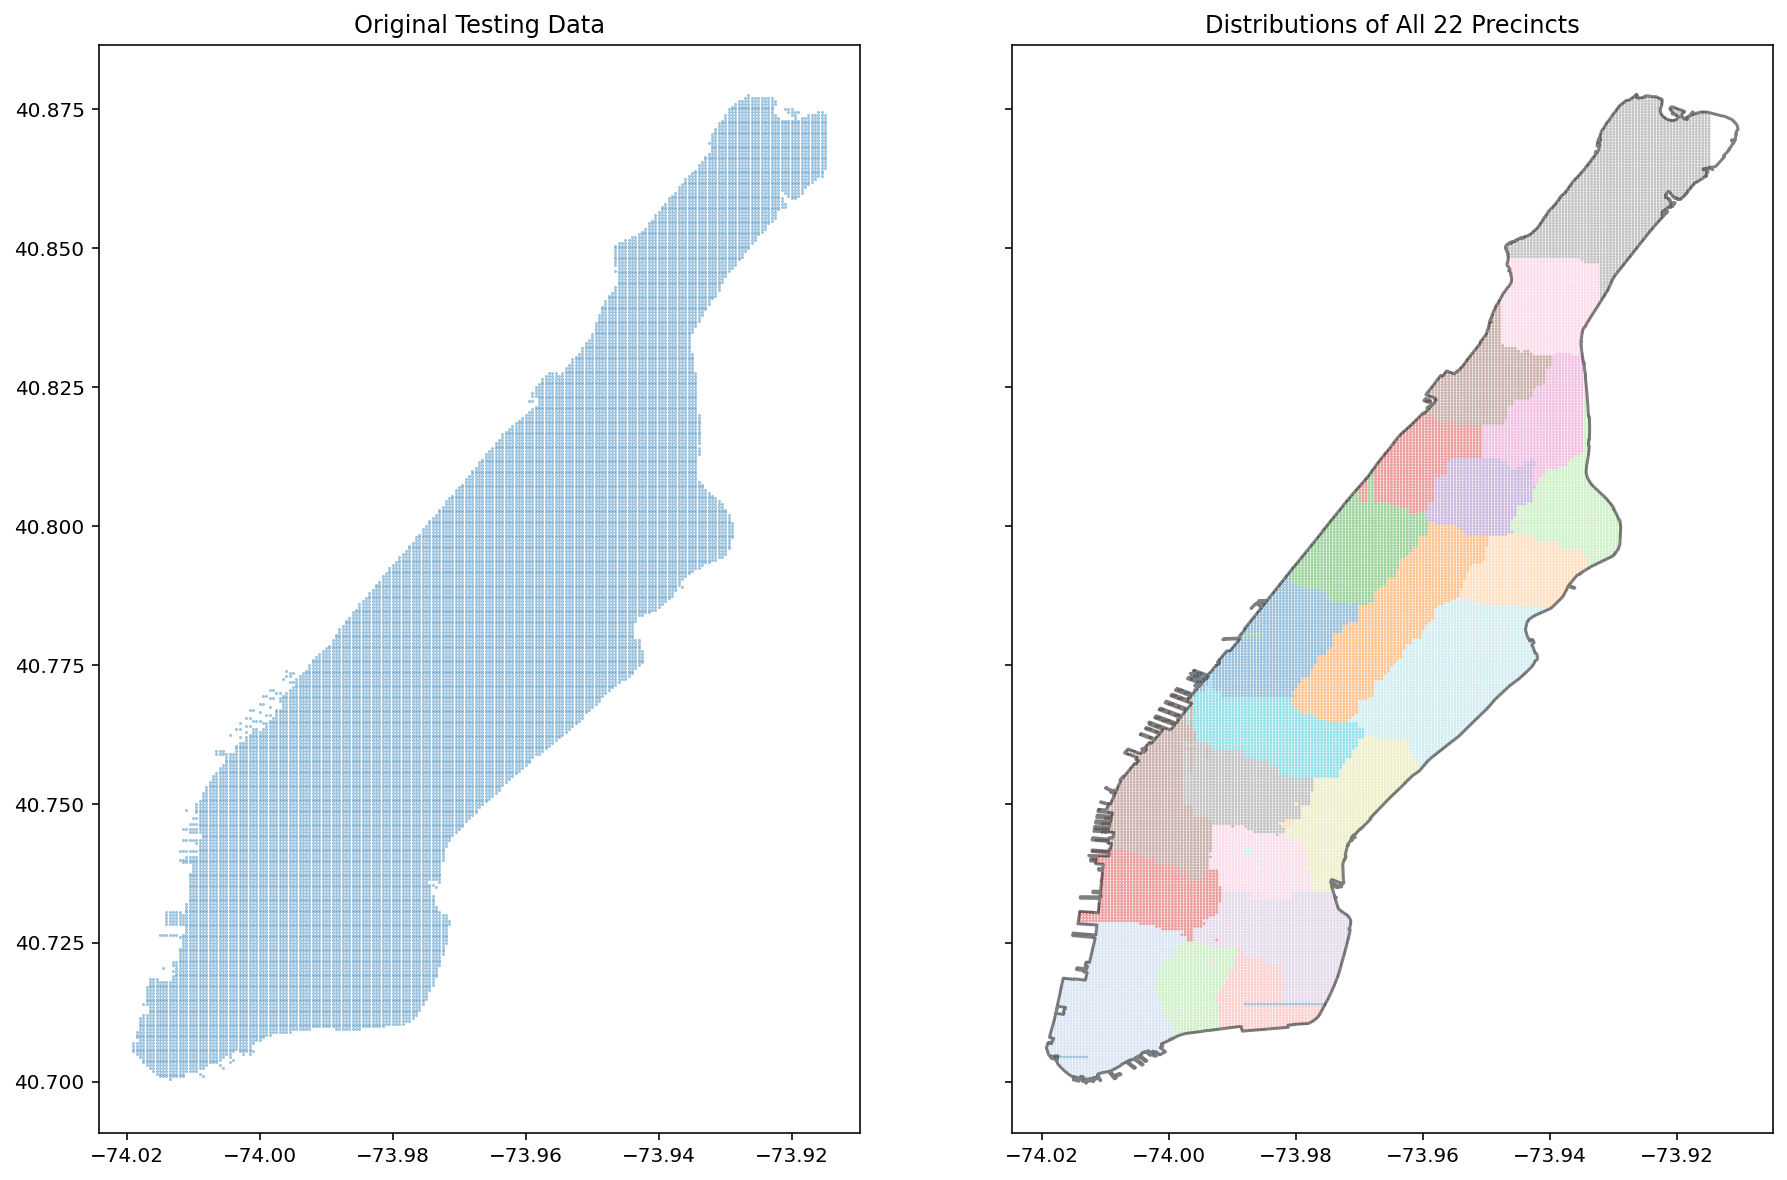

In [727]:
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey = True)

my_cmap = high_contrast_cmap

axs[0].scatter(X_oos['long'], X_oos['lat'], alpha=0.5, s=0.2)
axs[1].scatter(X_oos['long'], X_oos['lat'], c=my_cmap(y_pred_oos), alpha=0.5, s=0.2)
axs[1].plot(bound['long'], bound['lat'], c='black', alpha=0.5)

axs[0].set_title("Original Testing Data")
axs[1].set_title("Distributions of All 22 Precincts")

plt.show()